# Advanced sequence modeling for NLP


En esta sección, se aboradn diversos, tópcios, com es desde los modelos seq2seq que surgen la metodolgoía encoder-decorder, y por consiguiente la alineación de tokebns. Finalmente,técncias de como enteder polisemas.
## Encoder-decoder
    El primer caso, la metodología de encoder-decoder, permite tener un texto crudo, el modelo codifica este teto para saca alguna caracteristica, y finalmente lo decodicficada a un lenguaje humano interpretable. Un ejemplo sería como el anterior generador de texto, ya que tnemos el modelo RNN-GRU que tienela parte oculta en el tiempo, que es el encoder, y la parte del decorder, estener toda la lista de ancionaldiades para definir que apellidos son de ciertas nacionalidades.
## Alineación
    Con esta metodolgoía se intena alinear primerarnete los tokebne,s por ejem´plo, cundo un o escribe en un teclado de cleular, podemos tener mutliples repsuestas de cuandoe scribimos casa para escribir en al siguiente frase. Un ejemplo de esto sería, que si escribe la casa, antes ya me habrá escrito una casa.
Entonces, esto implica que un texto pude tener mutliples posibles respeustas, y es lo qyue necesita atacr, ¿Como puedo encontrar mutliples respuestas para una sola entrada?, y entramos con analisi bidreccional, porque por ejemplo, para comprender la semántica de  una palabra, podemos emepzar con la primera aprocximación de utilizar la parte anterior a la palabra, ya la sigueinte de la palabra la analizamos tabien,a mbos con modelos de redes recurrentes, entonces, se conatenan los resultados, y decoodificamos el resultado. El rpoblema de esto e s que los modelos recurrentes son poco paralelizables, si bien, es un divide y venceras de priemras, pero no puede ser paralelizado por palabra y necesita comprender el cotnexto completo para dar una respeusta completa sobre una mima palabra.

#Atención

El termino de atención surge del neuroanálisis, en el que como los humanos podemos comprender las cosas. Por lo general, al leer, no entedemos todos como un string  llano, suino que hay palabras que ñlas marcamos como ideas calves y analizanmos el contexto d e estas palabras para poder comprender us signficado. En traducción, por ejemplo, intetnamos comprender la palabra nnueva o ddesconocida, en base a palabras cirucndantes o que podemos asiganr con matyor peso parapodre comrpedenr el significado o traducciónd e esta palabra.

La atención puede urgir de diferents formas, como por ejemplo peude ser que el análisis sea local, o que sea global, pero esto nos permite hac el proceswo paralelzibale a diferencia de los modelos recurrentes.

En este colab contendrá una peuqeña idea de la atención y de como itnroducir conceptos clae como query,clave y valor.

# maquina de traudcción neuroanl
Es una técnica en al que se busca cque comptuacionalemnte puieda traducir un texto de un idioma a otr o idioma,. Esta tarea ha liderado la investigación fuerte con repsecto a la atencióbn, ya que tener un gran compendio de las palabras para pdoer traducir unaa plaabra resulta complicado, ya que muchas traducciones pueden ser más interpretativas que directs ddeundiccionario. 

Aquí srugen diversas, metricas como BLEU, ROUGE, METEOR.Que miden que tan bien se traduce de un idioma a otro.
El perplexity por su parte m ide la probabildiad en que una palabra ´pueda ocurrir dado un evento, esto surge de la teoria de la información y por lo tanto, tiene intrinsecamente la entropía cruzada, como se puede ver en la formula.

$$Perplexity(x)=2^{-P(x)\log P(x)}$$

# Preprocessamiento

> Para esta sección, se debe de hacer un preprocesameinto de los datos en crudo
>
> La primera etapa es definir nuestros párametros con argprase, sucesivamente, leemos ela rchivo de texto y separamos,reemplazamos los saltos de linea, lo hacemos minuscuals y dividmos el onjunto en dos tuplas a traves de \t, esto porque con \t esta la separacion entre ingles y frances para cada linea de nuestro arhcivo de texto.
> Sucesivamente, filtramos nuestro conjunto con reglas establecidas de palabras que empiezan con pronombres en presente, esto para reducir y convergerel tiempo de entrenamiento den nuestro modelo

In [1]:
from argparse import Namespace
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import nltk
#nltk.download("punkt_tab")

In [2]:
args = Namespace(
    source_data_path="data/nmt/eng-fra.txt",
    output_data_path="data/nmt/simplest_eng_fra.csv",
    perc_train=0.7,
    perc_val=0.15,
    perc_test=0.15,
    seed=1337
)

In [3]:
with open(args.source_data_path, encoding="utf-8") as fp:
    lines=fp.readlines()
lines=[line.replace("\n","").lower().split("\t") for line in lines]
print(lines[:10])

[['go.', 'va !'], ['run!', 'cours\u202f!'], ['run!', 'courez\u202f!'], ['wow!', 'ça alors\u202f!'], ['fire!', 'au feu !'], ['help!', "à l'aide\u202f!"], ['jump.', 'saute.'], ['stop!', 'ça suffit\u202f!'], ['stop!', 'stop\u202f!'], ['stop!', 'arrête-toi !']]


In [4]:
filter_phrases = (
    ("i", "am"), ("i", "'m"), 
    ("he", "is"), ("he", "'s"),
    ("she", "is"), ("she", "'s"),
    ("you", "are"), ("you", "'re"),
    ("we", "are"), ("we", "'re"),
    ("they", "are"), ("they", "'re")
)

In [5]:
data=[]
for english,french in lines:
    data.append({"english_tokens":word_tokenize(english,language="english"),"french_tokens":word_tokenize(french,language="french")})

In [6]:
subdataset={phrase: [] for phrase in filter_phrases}
for datum in data:
    key=tuple(datum["english_tokens"][:2])
    if key in subdataset:
        subdataset[key].append(datum)
    

In [7]:
counts ={k:len(v) for k,v in subdataset.items()}
counts,sum(counts.values())

({('i', 'am'): 805,
  ('i', "'m"): 4760,
  ('he', 'is'): 1069,
  ('he', "'s"): 787,
  ('she', 'is'): 504,
  ('she', "'s"): 316,
  ('you', 'are'): 449,
  ('you', "'re"): 2474,
  ('we', 'are'): 181,
  ('we', "'re"): 1053,
  ('they', 'are'): 194,
  ('they', "'re"): 470},
 13062)

# Sección de división del dataset a entrenamiento, validación y test

In [8]:
np.random.seed(args.seed)
dataset_stage3=[]
for phrase,datum_list in sorted(subdataset.items()):
    np.random.shuffle(datum_list)
    n_train=int(len(datum_list)*args.perc_train)
    n_val=int(len(datum_list)*args.perc_val)
    for datum in datum_list[:n_train]:
        datum["split"]="train"
    for datum in datum_list[n_train:n_train+n_val]:
        datum["split"]="val"
    for datum in datum_list[n_train+n_val:]:
        datum["split"]="test"
    dataset_stage3.extend(datum_list)
        
    

In [9]:
for datum in dataset_stage3:
    datum["source_language"]=" ".join(datum.pop("english_tokens"))
    datum["target_language"]=" ".join(datum.pop("french_tokens"))

## Creación del datafrma 
> Previamente se ghizo entoncesw  el etiquetadto de que datos estyán en entrenamiento y que datos están en valdiación a su vez de test, además se agregan las keys de lenguaje guenten a  lenguaje de objetivo
> Con esto podemos crearm el dataframe patra ya utilziarlo ewn un csv

In [10]:
nmt_df=pd.DataFrame(dataset_stage3)
nmt_df.head()

,split,source_language,target_language
0,train,he 's the cutest boy in town .,c'est le garçon le plus mignon en ville .
1,train,he 's a nonsmoker .,il est non-fumeur .
2,train,he 's smarter than me .,il est plus intelligent que moi .
3,train,he 's a lovely young man .,c'est un adorable jeune homme .
4,train,he 's three years older than me .,il a trois ans de plus que moi .


In [11]:
nmt_df.to_csv(args.output_data_path)

# La etapa del modelo
> Antes de crear el modelo, necesiatmos generar estructuras de datos que ermitan a pytorhc conocer nuestro modelo, por lo tanto necesiamtos un vectorizador, sin embarog, también necesitamos primero el vocabulario y el vocabualry seuqence

In [12]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence,pad_packed_sequence
from torch.nn import functional as F
import torch.optim as optim

In [13]:

class Vocabulary(object):
    """ Clase a procesar texto y extrar el vocabulario para mappear"""
    def __init__(self,token_to_idx=None,add_unk=True,unk_token="<UNK>"):
        """Args:
            token_to_idx (dict): un mapa pre existen de toknes a indices
            add_unk(bool): un bandera que indica si se añade el token UNK de desconocido
            unk_token(str): el token UNK se añade a el vocabulario
            """
        if token_to_idx is None:
            token_to_idx={}
        self._token_to_idx=token_to_idx
        self._idx_to_token={idx: token
                           for token,idx in self._token_to_idx.items()}
        self._add_unk=add_unk
        self._unk_token=unk_token
        self.unk_index=-1
        if add_unk:
            self.unk_index=self.add_token(unk_token)
    def to_serializable(self):
        """ Retorna un diccionario que puede ser serializado """
        return {"token_to_idx":self._token_to_idx,
               "add_unk":self._add_unk,
               "unk_token":self._unk_token}
    @classmethod
    def from_serializable(cls,contents):
        """instancia el bocabulario desde un diccionario serializado"""
        return cls(**contents)
    def add_token(self,token):
        """
        Actualiza los mapeos de diccionarrios basados en los tokens
        Args:
            token (str): el item a añadir en el vocabulario
        Returns:
            index(int) : el entero correspondiente al token
        """
        if token in self._token_to_idx:
            index=self._token_to_idx[token]
        else:
            index=len(self._token_to_idx)
            self._token_to_idx[token]=index
            self._idx_to_token[index]=token
        return index
    def lookup_token(self,token):
        """ Obtiene el indice asociado con el tokenn de UNK token si el token no está presente,
        Args:
            token (str): el token a observar
        returns :
            index (int) el indices correspondiente al token
        Notes:
               `unk_index` necesita ser entero positivo (habiendo sido añadido al vocabulario) para la funcionalidad desconocidad
               """
        if self._add_unk:
            return self._token_to_idx.get(token,self.unk_index)
        else:
            return self._token_to_idx[token]
    def lookup_index(self,index):
        """ Obtiene el token asociado al indice
        Args:
            index (int): el indice a observar
        returns :
            token (str) el token correspondiendte al indices
        Raises:
            KeyError: si el indice no está en el vocabulario
        """
        if index not in self._idx_to_token:
            raise KeyError("El indice (%d)no está en el vocabulario" % index)
        return self._idx_to_token[index]
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    def __len__(self):#Refleja la longitudad del vocabulario
        return len(self._token_to_idx)

## secuncia vocabualri

In [14]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

# Vectorizador

In [15]:
class NMTVectorizer(object):
    """
    El vecto4rizador que cordinate el vocabulario y lo coloca para usarlo
    """
    def __init__(self,source_vocab,target_vocab, max_source_length, max_target_length):
        """
        args:
        source_vocab(SequenceVocabulary): mapea la fuente de las palabras a enteros
        target_vocab(SequenceVocabulary): mapea las palabras obejtivo a enteros
        max_source_length(int): la secuencia mas larga en el conjutnod e datos fuente
        max_target_length(int): la secuencia mas larga en el conjutnot de datos objetivo
        """
        self.source_vocab=source_vocab
        self.target_vocab=target_vocab
        self.max_source_length=max_source_length
        self.max_target_length=max_target_length
    @classmethod
    def from_dataframe(cls,bittext_df):
        """Instancia al vectorizador desde el dataframe de conjunto de datos
        args:
        bittext_df: (pandas.DataFrame): el texto paralelo al conjunto de datos
        Retrun:
        una instancia de NMTVectorizer
        """
        source_vocab= SequenceVocabulary()
        target_vocab= SequenceVocabulary()
        max_source_length,max_target_length=0,0
        for _, row in bittext_df.iterrows():
            source_tokens=row["source_language"].split(" ")
            if len(source_tokens)>max_source_length:
                max_source_length=len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            target_tokens=row["target_language"].split(" ")
            if len(target_tokens)>max_target_length:
                max_target_length=len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
        return cls(source_vocab,target_vocab,max_source_length,max_target_length)
    def _vectorize(self,indices, vector_length=-1, mask_index=0):
        """vectoriza los indices dados
        args:
            indices(list): una lista de enteros que representa una secuencia
            vector_length (int): forza la longitrud del vector indice
            mask_index (int): el mask_index a usar; casis iemrpe es 0
        """
        if vector_length<0:
            vector_length=len(indices)
        vector =np.zeros(vector_length,dtype=np.int64)
        vector[:len(indices)] =indices
        vector[len(indices):]=mask_index
        return vector
    def _get_source_indices(self,text):
        """Retorna la fuente de texto vecotrizada
        args:
            text(str): la fuente de texto, tokens que deberian ser separados por espacios
        Returns:
            indices(list): lista de neteros que representan el texto
            """
        indices=[self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    def _get_target_indices(self,text):
        """Retorna la fuente del vector

        args:
            text(str): la fuente de texto; tokjens que deberian ser separados por espacios
        returns:
            una tupla :(x_indices, y_indices)
                x_indices (list): lista de enteros; observaciones en un decoder objetvio
                y_indices (lista): una lsit ade enteros, predicciones en un objetivo de decodficiador
        """
        indices=[self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices =[self.target_vocab.begin_seq_index]+indices
        y_indices= indices+[self.target_vocab.end_seq_index]
        return x_indices,y_indices
    def vectorize(self,source_text,target_text,use_dataset_max_lengths=True):
        """
        Retorna la fuente vectorizada y el texto objetivo

        args:
            source_text (str): texto desde el lneguaje original
            target_text (str): texto desde el lenguaje objetiuvo
            use_dataset_max_lengths (bool): si el uso del vector maximo de lñongitudes
            Retoran 
            los datos vectorizados como un diccionario con llaves
        """
        source_vector_length=-1
        target_vector_length=-1
        if use_dataset_max_lengths:
            source_vector_length=self.max_source_length+2
            target_vector_length=self.max_target_length+1
        source_indices=self._get_source_indices(source_text)
        source_vector=self._vectorize(source_indices,
                                      vector_length=source_vector_length,
                                      mask_index=self.source_vocab.mask_index)
        target_x_indices, target_y_indices =self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                          vector_length=target_vector_length,
                                          mask_index=self.target_vocab.mask_index)
        target_y_vector =self._vectorize(target_y_indices,vector_length=target_vector_length,
                                         mask_index=self.target_vocab.mask_index)
        return {
            "source_vector": source_vector,
            "target_x_vector": target_x_vector,
            "target_y_vector":target_y_vector,
            "source_length":len(source_indices)
        }
        

# Dataset

In [16]:
class NMTDataset(Dataset):
    # Se hereda la clase Dataset
    def __init__(self,text_df,vectorizer):
        """
        Args:
            review_df(pandas.DataFrame): El conjunto de datos
            vectorizer(ReviewVectorizer): vectorizer instacinado desde el conjunto de datos
        """
        self.text_df = text_df
        print(len(self.text_df))

        #self._max_seq_length = max(map(len, self.surname_df.surname)) + 2
        self._vectorizer = vectorizer
        self.train_df= self.text_df[self.text_df.split=="train"]
        self.train_size=len(self.train_df)

        self.val_df= self.text_df[self.text_df.split=="val"]
        self.val_size=len(self.val_df)

        self.test_df= self.text_df[self.text_df.split=="test"]
        self.test_size=len(self.test_df)

        self._lookup_dic={'train':(self.train_df,self.train_size),
                         'val':(self.val_df,self.val_size),
                         'test':(self.test_df,self.test_size),
                         }
        self.set_split("train")
        print("Total:", len(self.text_df))
        print("Train:", len(self.train_df))
        print("Val:", len(self.val_df))
        print("Test:", len(self.test_df))
        print(self.text_df.split.value_counts())
    @classmethod
    def load_dataset_and_make_vectorizer(cls,dataset_csv):
        """
        carga el dataset y hacer un nuevo vectorizador desde cero
        args:
                review_cvs(str): ubicacion del dataset
        Returns:
            una instancia de ReviewDataset
        """
        text_df= pd.read_csv(dataset_csv)
        train_subset_df = text_df[text_df.split=='train']
        return cls(text_df,NMTVectorizer.from_dataframe(train_subset_df))
    def get_vectorizer(self):
        """retorna el vectorizador"""
        return self._vectorizer
    def set_split(self,split="train"):
        """
        Selecciona la division en el conjunto de datos usando una columna en el dataframe
        args:
        split(str):  uno de "train","val","test"
        """
        self._target_split=split
        self._target_df,self._target_size=self._lookup_dic[split]
    def __len__(self):
        return self._target_size
    def __getitem__(self,index):
        """
        El punto primario de entrada como metodo para PyTorch en lso conjuntos de datos
        Args:
        index(int): Es el inice del dato
        Returns:
            Diccionario de las caracterizitcads de los puntos de datos y labels
        """
        row=self._target_df.iloc[index]
        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)
        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
    def get_num_batches(self,batch_size):
        """
        Dado un tamaño de batch , retorna el numero de batches del conjunto de datos
        Args:
            batch_size(int)
        Returns:
            Numero de batches en el conjuntos
        """
        return len(self)//batch_size
def generate_nmt_batches(dataset,batch_size,shuffle=True,drop_last=True,device="cpu"):
    """Una funciona generador que wrapea el dataloader de pytorch para NMT version"""
    dataloader=DataLoader(dataset=dataset,batch_size=batch_size,drop_last=drop_last,shuffle=shuffle)
    for data_dict in dataloader:
        lengths=data_dict["x_source_length"].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        out_data_dict={}
        for name,tensor in data_dict.items():
            out_data_dict[name]= data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

# Modelo Encoding-Decoding para NMT

> El codificador embebe las palabras del idioma de origne y extrae caracteristicas con un bi-GRU

In [41]:
class NMTEncoder(nn.Module):
    def __init__(self,num_embedding,embedding_size,rnn_hidden_size):
        """
        args:
        num_embeddings(int): tamaño del vocabulario de orgien
        embedding_size (int): tamaño de los vectores de embeddings
        rnn_hiddne_size (int): tamaño de los vectores de estados ocultos de los RNN
        """
        super(NMTEncoder,self).__init__()
        self.source_embedding = nn.Embedding(num_embedding,embedding_size,padding_idx=0)
        self.birnn=nn.GRU(embedding_size,rnn_hidden_size,bidirectional=True,batch_first=True)
    def forward(self,x_source,x_lengths):
        """El paso hacia adelante del modelo
        args:
            x_source(torch.Tensor): la entrada de datos
        x_source.shape(batch,seq_size)
        x_lengths (torch.Tensor): vector d elongitudes para cada item en el abtch
        Returns:
        una tupla : x_unpacked (torch.Tesnor),x:_birnn_h (torch.Tensor)
        """
        x_embedded=self.source_embedding(x_source)
        x_lengths=x_lengths.detach().cpu().numpy()
        x_packed =pack_padded_sequence(x_embedded,x_lengths,batch_first=True)
        x_birnn_out ,x_birnn_h =self.birnn(x_packed)
        x_birnn_h=x_birnn_h.permute(1,0,2)
        x_birnn_h=x_birnn_h.contiguous().view(x_birnn_h.size(0),-1)
        x_unpacked, _ = pad_packed_sequence(x_birnn_out,batch_first=True)
        return x_unpacked,x_birnn_h

### Sistema de atencion

In [50]:
def verbose_attention(encoder_state_vectors,query_vector):
    """encoider_state_vectors: 3dim tsnfro de bigru en le encoder
    query_evctor: un estado oculto del decoder de GRU
    """
    batch_size,num_vectors,vector_size =encoder_state_vectors.size()
    vector_scores= torch.sum(encoder_state_vectors*query_vector.view(batch_size,1,vector_size),dim=2)
    vector_probabilities =F.softmax(vector_scores,dim=1)
    weighted_vectors =encoder_state_vectors*vector_probabilities.view(batch_size,num_vectors,1)
    context_vectors=torch.sum(weighted_vectors,dim=1)
    return context_vectors,vector_probabilities,vector_scores
def terse_attention(encoder_state_vectors,query_vector):
    """
    encoder_state_vectors: 3dim tensor from bi-GRU in encoder
    query_vector: hidden state
    """
    vector_scores =torch.matmul(encoder_state_vectors,query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilites=F.softmax(vector_scores,dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2,-1),
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors,vector_probabilites
    

## Decoder 

In [51]:
class NMTDecoder(nn.Module):
    def __init__(self, num_embedding, embedding_size, rnn_hidden_size, bos_index):
        """
        Args:
            num_embeddings (int):Numero de embeddings que tambien es el numero de palabras unicas de la fuente objetiuvo
            embedding_size (int): tamaño del vector de embedding
            rnn_hidden_size (int): tamaño del estado oculto de la RNN
            bos_index(int): begin-of-sequence indices
        """
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embedding, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embedding)
        self.bos_index = bos_index
        self._sampling_temperature = 3
    def _init_indices(self, batch_size):
        """ return the BEGIN-OF-SEQUENCE index vector """
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        """ return a zeros vector for initializing the context """
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence, sample_probability=0.0):
        """El paso hacia adelante del modelo
        
        Args:
            encoder_state (torch.Tensor): la salida del NMTEncoder
            initial_hidden_state (torch.Tensor): El ultimo estado oculto del  NMTEncoder
            target_sequence (torch.Tensor): el tensor de datos del texto objetivo
            sample_probability (float): el esquema dek muestreo de parametros
                de porbabilidades de usar las prediccioones del modelo en cada decoder paso
        Returns:
            output_vectors (torch.Tensor): vectores de predicción para cada paso en la salida
        """
        if target_sequence is None:
            sample_probability = 1.0
        else:
            # We are making an assumption there: The batch is on first
            # The input is (Batch, Seq)
            # We want to iterate over sequence so we permute it to (S, B)
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)
        
        # use the provided encoder hidden state as the initial hidden state
        h_t = self.hidden_map(initial_hidden_state)
        
        batch_size = encoder_state.size(0)
        # initialize context vectors to zeros
        context_vectors = self._init_context_vectors(batch_size)
        # initialize first y_t word as BOS
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            # Schedule sampling is whe
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
                
            # Step 1: Embed word and concat with previous context
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # Step 2: Make a GRU step, getting a new hidden vector
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # Step 3: Use the current hidden to attend to the encoder state
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # auxillary: cache the attention probabilities for visualization
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # Step 4: Use the current hidden and context vectors to make a prediction to the next word
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            if use_sample:
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1)
                # _, y_t_index = torch.max(p_y_t_index, 1)
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()
            
            # auxillary: collect the prediction scores
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors

> El modelo NMTmodel coordina y encapsula la parte encoder y decoder en un solo forward

In [52]:
class NMTModel(nn.Module):
    def __init__(self,source_vocab_size, source_embedding_size, 
                 target_vocab_size,target_embedding_size, encoding_size, target_bos_index):
        """args

        source_vocab_size (int): numero de palabras unicas en el idioma fuente
        source_embedding_size (int): tamaño de los vectores de embeddings de la fuente
        target_vocab_size (int) : numero de palabras unicas en el idioma objetivo
        target_embedding_size (int): tamaño de los vecotres de embeddings objetivo
        encodign_size(int): tamaño del encoder RNN
        target_bos_index (int): indicespara BEGIN-OF-SEQUENCE token
        """
        super(NMTModel,self).__init__()
        self.encoder= NMTEncoder(num_embedding=source_vocab_size,
                                 embedding_size=source_embedding_size,
                                 rnn_hidden_size=encoding_size)
        decoding_size= encoding_size*2
        self.decoder=NMTDecoder(num_embedding=target_vocab_size,
                                 embedding_size=target_embedding_size,
                                 rnn_hidden_size=decoding_size,
                                   bos_index=target_bos_index)
    def forward(self,x_source, x_source_lengths, target_sequence,sample_probability=0.0):
        """ el paso hacioa adelante del modelo
        args:
        x_source (torch.Tensor): la fuente de datos de origen del tensor
            x_source.shape sera de (batch,vectorizer.max_sequence_lenghts)
        x_source_lengths (torch.Tensor): la longitu de las secuencias en x_source
        target_sequence(torch.Tensor): el objetivo del tensor de datos de texto
    Returns:
        decoded_states (torch.Tensor): las predicciones de los vecotres en el paso de salida
        """
        encoder_state, final_hidden_states=self.encoder(x_source,x_source_lengths)
        decoded_states= self.decoder(encoder_state=encoder_state, initial_hidden_state=final_hidden_states,
                                    target_sequence=target_sequence,
                                    sample_probability=sample_probability)
        return decoded_states
    

In [53]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

In [54]:
import os
args = Namespace(dataset_csv="data/nmt/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="model",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=32,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=24, 
                 target_embedding_size=24,
                 encoding_size=32,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model\vectorizer.json
	model\model.pth
Using CUDA: True


In [55]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)

vectorizer = dataset.get_vectorizer()

13062
Total: 13062
Train: 9138
Val: 1955
Test: 1969
split
train    9138
test     1969
val      1955
Name: count, dtype: int64


In [56]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("Reloaded model")
else:
    print("New model")

New model


In [60]:

model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

dataset.set_split('train')

dataset.set_split('val')


try:
    for epoch_index in range(args.num_epochs):
        sample_probability = (20 + epoch_index) / args.num_epochs
        
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()

            # -----------------------------------------
            # compute the running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the running loss and accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        
except KeyboardInterrupt:
    print("Exiting loop")

In [69]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [70]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [71]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(np.float64(0.4092395009232586), np.float64(0.41345446951562914))

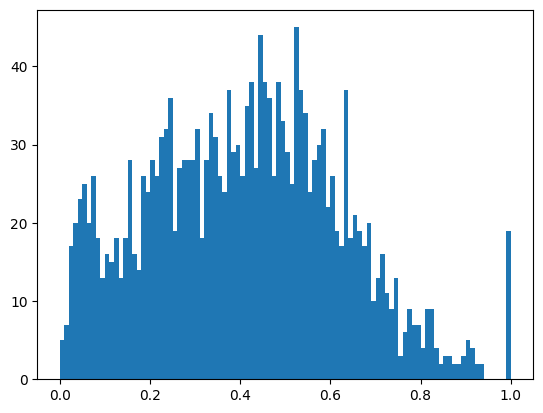

In [72]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [73]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "i 'm sorry that you 've been badly injured .",
 'truth': 'je suis désolé que vous ayez été gravement blessé .',
 'sampled': 'je suis désolé de vous avoir avoir été ça .'}